In [1]:
import os
import requests
import fitz
from tqdm.auto import tqdm
import random
import pandas as pd
from spacy.lang.en import English
import re
import torch
import numpy as np

In [2]:
pdf_path = "INVIDI Pulse™ Documentation.pdf"

if not os.path.exists(pdf_path):
    print("[INFO] File doesn't exist, downloading...")

    url = "https://invidi-uat.fluidtopics.net/r/INVIDI-Pulse-Documentation"

    filename = pdf_path

    response = requests.get(url)

    if response.status_code == 200:
        with open(filename, "wb") as file:
            file.write(response.content)
        print(f"[INFO] The file has been downloaded and saved as {filename}")
    else:
        print(f"[INFO] Failed to download the file. Status code: {response.status_code}")

else:
    print(f"File {pdf_path} exits.")

File INVIDI Pulse™ Documentation.pdf exits.


In [3]:
def text_formatter(text: str) -> str:
    cleaned_text = text.replace("\n", " ").strip()
    return cleaned_text

In [4]:
def open_and_read_pdf(pdf_path: str) -> list[dict]:
    doc = fitz.open(pdf_path)
    pages_and_texts = []

    for page_number, page in tqdm(enumerate(doc)):
        text = page.get_text()
        text = text_formatter(text=text)
        pages_and_texts.append({"page_number": page_number - 10,
                                "page_char_count": len(text),
                                "Page_word_count": len(text.split(" ")),
                                "page_sentence_count_raw": len(text.split(" ")),
                                "page_token_count": len(text)/4, # 1 token ~= 4 characters and 100 tokens ~= 75 words
                                "text": text
                                })
    return pages_and_texts

pages_and_texts = open_and_read_pdf(pdf_path= pdf_path)
print(pages_and_texts[:2])

0it [00:00, ?it/s]

[{'page_number': -10, 'page_char_count': 237, 'Page_word_count': 29, 'page_sentence_count_raw': 29, 'page_token_count': 59.25, 'text': 'counter(pages) PROPRIETARY AND CONFIDENTIAL INFORMATION OF INVIDI. (c) 2022  INVIDI Technologies Corporation. ALL RIGHTS RESERVED INFORMATION PLATFORM INVIDI Pulse™ Documentation Printed from the INVIDI Information Platform on 2025-03-19'}, {'page_number': -9, 'page_char_count': 188, 'Page_word_count': 24, 'page_sentence_count_raw': 24, 'page_token_count': 47.0, 'text': 'INVIDI Pulse&trade; Documentation  Displayed in the header counter(pages) PROPRIETARY AND CONFIDENTIAL INFORMATION OF INVIDI. (c) 2022  INVIDI Technologies Corporation. ALL RIGHTS RESERVED'}]


In [5]:
print(random.sample(pages_and_texts, k=3))

[{'page_number': 264, 'page_char_count': 3063, 'Page_word_count': 460, 'page_sentence_count_raw': 460, 'page_token_count': 765.75, 'text': 'INVIDI Pulse&trade; Documentation  Displayed in the header counter(pages) PROPRIETARY AND CONFIDENTIAL INFORMATION OF INVIDI. (c) 2022  INVIDI Technologies Corporation. ALL RIGHTS RESERVED Programmatic (SSP) NOTE:  This functionality needs to be enabled for you account. Contact your designated INVIDI representative if you want to use Programmatic. INVIDI Pulse™ Programmatic, often referred to as INVIDI Pulse SSP, refers to an automated process of selling and buying ad space, also know as programmatic real-time bidding (RTB). It replaces the traditional relationship between sellers (the publishers) and buyers (the advertisers), which involves requests for proposals, human negotiations, and manual insertion orders. When the Programmatic functionality is enabled for your account, you see a new menu item in the INVIDI Pulse menu bar ( ). All functional

In [6]:
df = pd.DataFrame(pages_and_texts)
print(df.head())

   page_number  page_char_count  Page_word_count  page_sentence_count_raw  \
0          -10              237               29                       29   
1           -9              188               24                       24   
2           -8             2095              249                      249   
3           -7             2216              254                      254   
4           -6             2216              254                      254   

   page_token_count                                               text  
0             59.25  counter(pages) PROPRIETARY AND CONFIDENTIAL IN...  
1             47.00  INVIDI Pulse&trade; Documentation  Displayed i...  
2            523.75  INVIDI Pulse&trade; Documentation  Displayed i...  
3            554.00  INVIDI Pulse&trade; Documentation  Displayed i...  
4            554.00  INVIDI Pulse&trade; Documentation  Displayed i...  


In [7]:
df.describe().round(2)

,page_number,page_char_count,Page_word_count,page_sentence_count_raw,page_token_count
count,884.00,884.00,884.00,884.00,884.00
mean,431.50,2764.63,510.55,510.55,691.16
std,255.33,1078.35,346.21,346.21,269.59
min,-10.00,188.00,24.00,24.00,47.00
25%,210.75,2033.25,330.75,330.75,508.31
50%,431.50,2634.50,442.00,442.00,658.62
75%,652.25,3372.50,584.00,584.00,843.12
max,873.00,9506.00,4140.00,4140.00,2376.50


In [8]:
nlp = English()

nlp.add_pipe("sentencizer")

# creating document instance as an example
doc = nlp("This is a sentence. This another sentence. I like burger.")
assert len(list(doc.sents)) == 3

list(doc.sents)

[This is a sentence., This another sentence., I like burger.]

In [9]:
pages_and_texts[100]

{'page_number': 90,
 'page_char_count': 2831,
 'Page_word_count': 466,
 'page_sentence_count_raw': 466,
 'page_token_count': 707.75,
 'text': 'INVIDI Pulse&trade; Documentation  Displayed in the header counter(pages) PROPRIETARY AND CONFIDENTIAL INFORMATION OF INVIDI. (c) 2022  INVIDI Technologies Corporation. ALL RIGHTS RESERVED Create or reuse a custom report Custom Reporting API Custom reporting request body overview Campaigns overview 2021-03-04 Release Ability to manipulate skip button settings through Campaign, Goal, and Ad API Skip button settings support in Campaign, Goal, and Ad API In Pulse, you can define whether a viewer should be able to skip an ad or not. The skip button behavior is configured in your insertion policies and inherited to campaigns, goals, and ads. When an advertiser wants a different skip button behavior than the one configured in your insertion policies, you can override the skip settings on the desired level. Previously, this was only possible through th

In [10]:
for item in tqdm(pages_and_texts):
    item["sentences"] = list(nlp(item["text"]).sents)

    item["sentences"] = [str(sentence) for sentence in item["sentences"]]

    item["page_sentence_count_spacy"] = len(item["sentences"])

  0%|          | 0/884 [00:00<?, ?it/s]

In [11]:
random.sample(pages_and_texts, k=1)

[{'page_number': 798,
  'page_char_count': 3165,
  'Page_word_count': 499,
  'page_sentence_count_raw': 499,
  'page_token_count': 791.25,
  'text': 'INVIDI Pulse&trade; Documentation  Displayed in the header counter(pages) PROPRIETARY AND CONFIDENTIAL INFORMATION OF INVIDI. (c) 2022  INVIDI Technologies Corporation. ALL RIGHTS RESERVED How does it work? Publishers (content owners) create a text file, named ads.txt, which contains a one line record for every ad tech platform that offers their inventory to buyers programmatically. Each record details the platform’s domain name, the publisher’s account ID, and the terms of the inventory representation. This data is already available in the OpenRTB protocol, making it simple to gather and target. Publishers host the ads.txt file on their root domain and any subdomain containing ad inventory to be sold programmatically, this way proving that the website authored the file. Buying platforms, typically DSPs, crawl publisher domains on a regul

In [12]:
df = pd.DataFrame(pages_and_texts)
df.describe().round(2)

,page_number,page_char_count,Page_word_count,page_sentence_count_raw,page_token_count,page_sentence_count_spacy
count,884.00,884.00,884.00,884.00,884.00,884.00
mean,431.50,2764.63,510.55,510.55,691.16,19.92
std,255.33,1078.35,346.21,346.21,269.59,12.37
min,-10.00,188.00,24.00,24.00,47.00,3.00
25%,210.75,2033.25,330.75,330.75,508.31,11.00
50%,431.50,2634.50,442.00,442.00,658.62,19.00
75%,652.25,3372.50,584.00,584.00,843.12,27.00
max,873.00,9506.00,4140.00,4140.00,2376.50,78.00


In [13]:
num_sentence_chunk_size = 10

# function to split lists of texts recursively into chunk size
def split_list(input_list: list[str], slice_size: int = num_sentence_chunk_size) -> list[list[str]]:
    return [input_list[i:i + slice_size] for i in range(0, len(input_list), slice_size)]

test_list = list(range(25))
split_list(test_list)

[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 [10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
 [20, 21, 22, 23, 24]]

In [14]:
for item in tqdm(pages_and_texts):
    item["sentence_chunks"]= split_list(input_list = item["sentences"],
                                       slice_size = num_sentence_chunk_size)
    item["num_chunks"] = len(item["sentence_chunks"])

  0%|          | 0/884 [00:00<?, ?it/s]

In [15]:
random.sample(pages_and_texts, k=1)

[{'page_number': 461,
  'page_char_count': 1636,
  'Page_word_count': 218,
  'page_sentence_count_raw': 218,
  'page_token_count': 409.0,
  'text': 'INVIDI Pulse&trade; Documentation  Displayed in the header counter(pages) PROPRIETARY AND CONFIDENTIAL INFORMATION OF INVIDI. (c) 2022  INVIDI Technologies Corporation. ALL RIGHTS RESERVED VAST and VMAP See VAST and VMAP for more information. //in VAST and VMAP, an extra parameter (pid) needs to be sent in the HTTP request  http://subdomain.videoplaza.tv/proxy/distributor/v2?rt=vast_3.0&tt=p&pid=2467a22f-9d74-406a-ab62-54fae1414af9 http://subdomain.videoplaza.tv/proxy/distributor/v2?rt=vmap_1.0&tt=p&pid=2467a22f-9d74-406a-ab62-54fae1414af9 HTML5 See Pulse HTML5 SDK for more information. setPulseHost(pulseHost, deviceContainer, persistentId, ignoreSecure, disableFlash); iOS See Pulse iOS SDK for more information. (void)setPulseHost:(NSString *)host    deviceContainer:(NSString *)deviceContainer       persistentId:(NSString *)persistentId; A

In [16]:
df = pd.DataFrame(pages_and_texts)
df.describe().round(2)

,page_number,page_char_count,Page_word_count,page_sentence_count_raw,page_token_count,page_sentence_count_spacy,num_chunks
count,884.00,884.00,884.00,884.00,884.00,884.00,884.00
mean,431.50,2764.63,510.55,510.55,691.16,19.92,2.46
std,255.33,1078.35,346.21,346.21,269.59,12.37,1.25
min,-10.00,188.00,24.00,24.00,47.00,3.00,1.00
25%,210.75,2033.25,330.75,330.75,508.31,11.00,2.00
50%,431.50,2634.50,442.00,442.00,658.62,19.00,2.00
75%,652.25,3372.50,584.00,584.00,843.12,27.00,3.00
max,873.00,9506.00,4140.00,4140.00,2376.50,78.00,8.00


### Splitting each chunk into its own item

We'd like to embed each chunk of sentences into its own numerical representation.

That will give us a good level of granularity.

Meaning, we can dive specifically into the text sample that was used in our model.

In [17]:
# splitting each chunk into its own item
pages_and_chunks = []
for item in tqdm(pages_and_texts):
    for sentence_chunk in item["sentence_chunks"]:
        chunk_dict = {}
        chunk_dict["page_number"] = item["page_number"]

        # joining the sentences together into a paragraph like structure, aka join the list of sentences into one paragraph
        joined_sentence_chunk = "".join(sentence_chunk).replace(" ", " ").strip()
        joined_sentence_chunk = re.sub(r'\.([A-Z])', r'. \1', joined_sentence_chunk)  # ".A" -> ". A" (will work for any capital letter)

        chunk_dict["sentence_chunk"] = joined_sentence_chunk

        # Getting some stats on our chunk
        chunk_dict["chunk_char_count"] = len(joined_sentence_chunk)
        chunk_dict["chunk_word_count"] = len([word for word in joined_sentence_chunk.split(" ")])
        chunk_dict["chunk_token_count"] = len(joined_sentence_chunk) / 4  # 1 token = ~4 chars

        pages_and_chunks.append(chunk_dict)

len(pages_and_chunks)

  0%|          | 0/884 [00:00<?, ?it/s]

2177

In [18]:
random.sample(pages_and_chunks, k=1)

[{'page_number': 116,
  'sentence_chunk': 'The account custom parameter values cannot contain any spaces or any of the following characters: comma (,), semicolon (;), double quote/quotation mark ("), single quote/apostrophe (\'), backslash (\\), pipe (|), tilde (~), or ampersand (&). Documentation releases This release includes the following documentation updates: INVIDI Pulse SDKs parameter reference Android Pulse SDK: Changelog iOS Pulse SDK: Changelog 2020-01-16 Release Improvements to Export VAST URL functionality. Export VAST URL improvements NOTE:  VAST URLs to campaign, goals and ads functionality needs to be enabled for your account. The ability to export VAST URLs for ad calls on campaign, goal and ad, and the ability to export VAST URLs for ad calls on category and content partner has been improved on. Now, you get two URLs for each ad call, one with VAST 2.0 response template, rt=vast_2.0, and one with VAST 3.0 response template, rt=vast_3.0. The platform parameter has chang

In [19]:
df = pd.DataFrame(pages_and_chunks)
df.describe().round(2)

,page_number,chunk_char_count,chunk_word_count,chunk_token_count
count,2177.00,2177.00,2177.00,2177.00
mean,422.40,1120.98,206.27,280.25
std,263.17,681.89,237.11,170.47
min,-10.00,1.00,1.00,0.25
25%,203.00,665.00,103.00,166.25
50%,392.00,1041.00,163.00,260.25
75%,665.00,1479.00,232.00,369.75
max,873.00,4923.00,2831.00,1230.75


### Fitering chunks of text for short chunks

These chunks may not contain much useful information

In [20]:
# show random chunks with under 30 tokens in length
min_token_length = 30
for row in df[df["chunk_token_count"] <= min_token_length].sample(5).iterrows():
    print(f'Chunk token count: {row[1]["chunk_token_count"]} | Text: {row[1]["sentence_chunk"]}')

Chunk token count: 3.75 | Text: 4. Click Share.
Chunk token count: 19.5 | Text: To add more items, repeat this step.3. Ignore parent audience targeting rules:
Chunk token count: 23.25 | Text: The following options are available: Danish English (UK) English (US) French German Norwegian
Chunk token count: 7.0 | Text: The eCPM of the goal is $45.
Chunk token count: 15.5 | Text: 100 TIME_SPENT Tracks the time the user spent watching the ad.


In [21]:
# Filter our dataframe for rows with under 30 tokens
pages_and_chunks_over_min_token_len = df[df["chunk_token_count"] > min_token_length].to_dict(orient = "records")
pages_and_chunks_over_min_token_len[:2]

[{'page_number': -10,
  'sentence_chunk': 'counter(pages) PROPRIETARY AND CONFIDENTIAL INFORMATION OF INVIDI. (c) 2022  INVIDI Technologies Corporation. ALL RIGHTS RESERVED INFORMATION PLATFORM INVIDI Pulse™ Documentation Printed from the INVIDI Information Platform on 2025-03-19',
  'chunk_char_count': 237,
  'chunk_word_count': 29,
  'chunk_token_count': 59.25},
 {'page_number': -9,
  'sentence_chunk': 'INVIDI Pulse&trade; Documentation  Displayed in the header counter(pages) PROPRIETARY AND CONFIDENTIAL INFORMATION OF INVIDI. (c) 2022  INVIDI Technologies Corporation. ALL RIGHTS RESERVED',
  'chunk_char_count': 188,
  'chunk_word_count': 24,
  'chunk_token_count': 47.0}]

In [22]:
random.sample(pages_and_chunks_over_min_token_len, k=1)

[{'page_number': 152,
  'sentence_chunk': 'This way, you could report on ad delivery on specific content you served, but only from a third-party reporting system. From March 7, 2018 Pulse also started recording this information, so you can pull reports based on your content IDs. To create reports on content ID in Pulse, you must send in the IDs in your integration(s) through: the content ID parameter in the content metadata object, when using the Pulse SDKs, HTML5 Ad Player or HTML5 Pulse SDK derived plugins, or the content ID parameter, when using direct VAST or VMAP requests. Custom Reporting updates The following new features have been released for Custom Reporting: Availability of content ID as dimension in both Custom Reporting REST API and User Interface, and as a filter in the Custom Reporting REST API. Documentation releases This release includes the following documentation updates: INVIDI Pulse SDKs parameter reference VAST and VMAP parameters Custom Reporting UI: Create or re

### Creating our embedding model --

In [23]:
from sentence_transformers import SentenceTransformer
embedding_model = SentenceTransformer(model_name_or_path="all-mpnet-base-v2",
                                      device = "cuda")

sentences = ["The Sentence Transformer library provides an easy way to create embeddings.",
             "Sentences can be embedded one by one or in a list.",
             "I like horses!"]

embeddings = embedding_model.encode(sentences)
embeddings_dict = dict(zip(sentences, embeddings))

for sentence, embedding in embeddings_dict.items():
    print(f"Sentence : {sentence}")
    print(f"Embedding : {embedding}")
    print("")

Sentence : The Sentence Transformer library provides an easy way to create embeddings.
Embedding : [-3.44285965e-02  2.95328684e-02 -2.33643446e-02  5.57256714e-02
 -2.19098590e-02 -6.47059549e-03  1.02849277e-02 -6.57803640e-02
  2.29717959e-02 -2.61120591e-02  3.80420908e-02  5.61402924e-02
 -3.68746147e-02  1.52787846e-02  4.37020846e-02 -5.19723333e-02
  4.89479043e-02  3.58104776e-03 -1.29750799e-02  3.54383094e-03
  4.23261970e-02  3.52606773e-02  2.49402113e-02  2.99177095e-02
 -1.99381392e-02 -2.39752494e-02 -3.33371968e-03 -4.30450365e-02
  5.72014116e-02 -1.32517638e-02 -3.54477875e-02 -1.13935880e-02
  5.55561371e-02  3.61092552e-03  8.88527381e-07  1.14027392e-02
 -3.82229947e-02 -2.43546581e-03  1.51313804e-02 -1.32679575e-04
  5.00659533e-02 -5.50876819e-02  1.73444878e-02  5.00959083e-02
 -3.75959389e-02 -1.04463482e-02  5.08322641e-02  1.24861011e-02
  8.67376179e-02  4.64142859e-02 -2.10690200e-02 -3.90251912e-02
  1.99694629e-03 -1.42345959e-02 -1.86795145e-02  2.8266

In [24]:
embeddings.shape

(3, 768)

In [25]:
embedding = embedding_model.encode("I like Machine Learning!")
embedding

array([-3.44425254e-02,  1.17710672e-01, -6.44084215e-02, -6.64401148e-03,
        9.13011283e-03,  2.95091178e-02, -1.94604993e-02, -1.34199318e-02,
        1.25236949e-02,  1.94387287e-02,  5.46944961e-02,  1.32130180e-02,
       -6.49770126e-02,  7.99014419e-02,  2.49031559e-02, -5.97645268e-02,
        1.16188070e-02, -2.82808132e-02, -1.15701295e-02,  2.43128166e-02,
       -2.85860244e-02,  1.80363394e-02, -9.06527508e-03, -2.90293572e-03,
       -2.31340472e-02, -1.44711370e-02, -2.09238399e-02, -8.17338154e-02,
        3.46628739e-03,  1.85845848e-02, -3.45555544e-02, -9.32086259e-04,
       -1.34428944e-02,  4.05862257e-02,  1.57819863e-06, -5.86344264e-02,
       -3.50901112e-02,  1.76233966e-02, -6.23913063e-03,  9.02268756e-03,
        5.04917167e-02, -2.20099092e-02, -2.10719425e-02, -2.48681242e-03,
       -4.18084301e-02,  4.70196940e-02,  7.80892819e-02, -3.97950672e-02,
       -3.59860307e-04,  4.67925109e-02, -1.14011727e-02,  2.05845688e-03,
       -6.04187585e-02, -

In [26]:
%%time

embedding_model.to("cuda")

# embedding each chunk one by one
for item in tqdm(pages_and_chunks_over_min_token_len):
    item["embedding"] = embedding_model.encode(item["sentence_chunk"])

  0%|          | 0/2122 [00:00<?, ?it/s]

CPU times: total: 2min 40s
Wall time: 2min 47s


In [27]:
%%time 

text_chunks = [item["sentence_chunk"] for item in pages_and_chunks_over_min_token_len]
text_chunks[419]

CPU times: total: 0 ns
Wall time: 0 ns


'Now, with the issue fixed, Pulse recognizes Edge browser correctly and only returns supported media files (such as MP4). Custom Reporting updates Some new features have been released for Custom Reporting: You can now browse through the content category structure in your account, in addition to using the text field, to select a content category to filter on when you create a report.'

In [28]:
len(text_chunks)

2122

### Saving embeddings to a file --

In [29]:
text_chunks_and_embeddings_df = pd.DataFrame(pages_and_chunks_over_min_token_len)
embeddings_df_save_path = "text_chunks_and_embeddings_df.csv"
text_chunks_and_embeddings_df.to_csv(embeddings_df_save_path, index=False)

In [30]:
text_chunks_and_embeddings_df_load = pd.read_csv(embeddings_df_save_path)
text_chunks_and_embeddings_df_load.head()

,page_number,sentence_chunk,chunk_char_count,chunk_word_count,chunk_token_count,embedding
0,-10,counter(pages) PROPRIETARY AND CONFIDENTIAL IN...,237,29,59.25,[-7.62315392e-02 -4.22073528e-02 -3.59832682e-...
1,-9,INVIDI Pulse&trade; Documentation Displayed i...,188,24,47.00,[-6.80130050e-02 -2.98340507e-02 -3.97457629e-...
2,-8,INVIDI Pulse&trade; Documentation Displayed i...,422,54,105.50,[-6.63345307e-02 -2.45578606e-02 -2.93102190e-...
3,-8,2024-11-28 Release 4.2.2.2024-11-22 Release 4....,252,21,63.00,[-1.76461693e-02 8.94903243e-02 -2.35387776e-...
4,-8,2024-06-26 Release 4.2.12.2024-06-19 Release 4...,256,22,64.00,[-1.67909581e-02 7.97286332e-02 -2.54111718e-...


In [31]:
device = "cpu"

text_chunks_and_embeddings_df = pd.read_csv("text_chunks_and_embeddings_df.csv")

# converting embedding column back to np.array (it got converted to string when it saved to CSV)
text_chunks_and_embeddings_df["embedding"] = text_chunks_and_embeddings_df["embedding"].apply(lambda x: np.fromstring(x.strip("[]"), sep = " "))

# converting our embeddings into torch.tensor
embeddings = torch.tensor(np.stack(text_chunks_and_embeddings_df["embedding"].tolist(), axis=0), dtype = torch.float32)

# converting texts and embedding df to list of dicts
pages_and_chunks = text_chunks_and_embeddings_df.to_dict(orient = "records")

text_chunks_and_embeddings_df

,page_number,sentence_chunk,chunk_char_count,chunk_word_count,chunk_token_count,embedding
0,-10,counter(pages) PROPRIETARY AND CONFIDENTIAL IN...,237,29,59.25,"[-0.0762315392, -0.0422073528, -0.0359832682, ..."
1,-9,INVIDI Pulse&trade; Documentation Displayed i...,188,24,47.00,"[-0.068013005, -0.0298340507, -0.0397457629, 0..."
2,-8,INVIDI Pulse&trade; Documentation Displayed i...,422,54,105.50,"[-0.0663345307, -0.0245578606, -0.029310219, 0..."
3,-8,2024-11-28 Release 4.2.2.2024-11-22 Release 4....,252,21,63.00,"[-0.0176461693, 0.0894903243, -0.0235387776, -..."
4,-8,2024-06-26 Release 4.2.12.2024-06-19 Release 4...,256,22,64.00,"[-0.0167909581, 0.0797286332, -0.0254111718, -..."
...,...,...,...,...,...,...
2117,872,It is often a blank screen or a short message ...,225,40,56.25,"[-0.0226768255, -0.0586868115, -0.00785847381,..."
2118,873,INVIDI Pulse&trade; Documentation Displayed i...,1423,220,355.75,"[-0.0565682389, -0.0363128707, -0.0391614847, ..."
2119,873,Metro area: the metropolitan area where your t...,1710,281,427.50,"[0.000205744815, -0.0741167217, -0.0296253096,..."
2120,873,Each time a viewer watches an ad associated wi...,789,129,197.25,"[0.0046419953, -0.0414108634, 0.00782874599, -..."


In [32]:
embeddings.shape

torch.Size([2122, 768])

In [33]:
# creating model
from sentence_transformers import util, SentenceTransformer

embedding_model = SentenceTransformer(model_name_or_path = "all-mpnet-base-v2",
                                      device = device)

Embedding model ready!!

Let's create a small semantic search pipeline.

In essence, we want to search for a query and get back relevant passages from our textbook.

We can do so with following steps:

1. Define a query string.
2. Turn the query string into an embedding.
3. Perform a dot product or cosine similarity function between the text embeddings and the query embedding.
4. Sort the results from 3 n descending order.


In [34]:
#1. Define the query
query = "How to create new ad?"
print(f"Query : {query}")

#2. Embed the query (Note:- it's important to to embed your query with the same model you embedding your passages)
query_embedding = embedding_model.encode(query, convert_to_tensor = True)

#3. Get similarity scores with the dot product 
from time import perf_counter as timer

start_time = timer()
dot_scores = util.dot_score(a = query_embedding, b = embeddings)[0]
end_time = timer()

print(f"[INFO] Time taken to get scores on {len(embeddings)} embeddings : {end_time-start_time: .5f} seconds.")

#4. Get the top-k results 
top_results_dot_product = torch.topk(dot_scores, k=5)
top_results_dot_product

Query : How to create new ad?
[INFO] Time taken to get scores on 2122 embeddings :  0.00572 seconds.


torch.return_types.topk(
values=tensor([0.6714, 0.6700, 0.6416, 0.5910, 0.5902]),
indices=tensor([557, 607, 547, 997, 604]))

In [35]:
larger_embeddings = torch.randn(100*embeddings.shape[0], 768).to(device)
print(f"Embeddings shape: {larger_embeddings.shape}")

start_time = timer()
dot_scores = util.dot_score(a = query_embedding, b = larger_embeddings)[0]
end_time = timer()

print(f"[INFO] Time taken to get scores on {len(larger_embeddings)} embeddings : {end_time-start_time: .5f} seconds.")

Embeddings shape: torch.Size([212200, 768])
[INFO] Time taken to get scores on 212200 embeddings :  0.03463 seconds.


We can see that searching over embeddings is very fast even if we do exhaustive.

But if you had 10M+ embeddings, you likely wwant to create an index.

An index is like letters in the dictionary.

For example, if you wanted to search "duck" in the dictionary, you'd start at "d" then find words close to "du..." etc.

An index helps to narrow it down.

A popular indexing library for vector search is FAISS.

One technique that the library provides is approximate nearest neighbour search (ANN).

In [36]:
import textwrap

def print_wrapped(text, wrap_length = 80):
    wrapped_text = textwrap.fill(text, wrap_length)
    print(wrapped_text)

In [37]:
query = "How to create new ad?"
print(f"Query: '{query}'\n")
print("Results:")

# looping through zipped together scores and indices from torch.topk
for score, idx in zip(top_results_dot_product[0], top_results_dot_product[1]):
    print(f"Score: {score:.4f}")
    print("Text:")
    print_wrapped(pages_and_chunks[idx]["sentence_chunk"])
    print(f"Page number: {pages_and_chunks[idx]['page_number']}")
    print("\n")

Query: 'How to create new ad?'

Results:
Score: 0.6714
Text:
To configure a new advertiser, enter the advertiser name and the advertiser will
be created after saving your campaign. Use up to 250 characters. NOTE:  For a
programmatic campaign, we suggest entering "SSP".d. Agency: select an agency
from the dropdown or start typing to get suggestions. To configure a new agency,
enter the agency name and the agency will be created after saving your campaign.
Use up to 250 characters.e. Brand: select a brand from the dropdown or start
typing to get suggestions. To configure a new brand, enter the brand name and
the brand will be created after saving your campaign. Use up to 250
characters.f. Description: add a description of your campaign for your own
internal reference.
Page number: 214


Score: 0.6700
Text:
Fill in the remaining fields: a. Name (required): enter the name of the ad. Use
up to 255 characters.b. Format (required): select the format of the ad.
Depending on the ad format you s

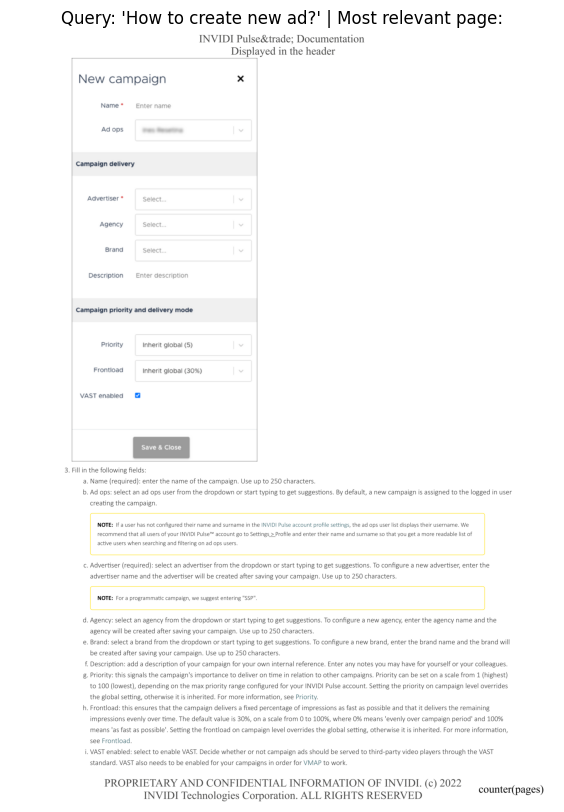

In [38]:
pdf_path = "INVIDI Pulse™ Documentation.pdf"
doc = fitz.open(pdf_path)
page = doc.load_page(214 + 10)

img = page.get_pixmap(dpi = 600, alpha = False)

doc.close()

img_array = np.frombuffer(img.samples_mv,
                          dtype = np.uint8).reshape((img.h, img.w, img.n))

import matplotlib.pyplot as plt
plt.figure(figsize = (13, 10))
plt.imshow(img_array)
plt.title(f"Query: '{query}' | Most relevant page:")
plt.axis("off")
plt.show()

### Similarity measures: Dot Product and Cosine Similarity

Two of the most common similarity measures between vectors are dot product and cosine similarity.

In essence, closer vectors will have higher scores, further away vectors will have lower scores.

In [39]:
embeddings.shape

torch.Size([2122, 768])

In [40]:
import torch

def dot_product(vector1, vector2):
    return torch.dot(vector1, vector2)

def cosine_similarity(vector1, vector2):
    dot_product = torch.dot(vector1, vector2)
    norm_vector1 = torch.sqrt(torch.sum(vector1 ** 2))
    norm_vector2 = torch.sqrt(torch.sum(vector2 ** 2))
    return dot_product / (norm_vector1 * norm_vector2)

vector1 = torch.tensor([1, 2, 3], dtype=torch.float32)
vector2 = torch.tensor([1, 2, 3], dtype=torch.float32)
vector3 = torch.tensor([4, 5, 6], dtype=torch.float32)
vector4 = torch.tensor([-1, -2, -3], dtype=torch.float32)

# Dot product
print("Dot product between vector1 and vector2:", dot_product(vector1, vector2))
print("Dot product between vector1 and vector3:", dot_product(vector1, vector3))
print("Dot product between vector1 and vector4:", dot_product(vector1, vector4))

# Cosine similarity
print("Cosine similarity between vector1 and vector2:", cosine_similarity(vector1, vector2))
print("Cosine similarity between vector1 and vector3:", cosine_similarity(vector1, vector3))
print("Cosine similarity between vector1 and vector4:", cosine_similarity(vector1, vector4))


Dot product between vector1 and vector2: tensor(14.)
Dot product between vector1 and vector3: tensor(32.)
Dot product between vector1 and vector4: tensor(-14.)
Cosine similarity between vector1 and vector2: tensor(1.0000)
Cosine similarity between vector1 and vector3: tensor(0.9746)
Cosine similarity between vector1 and vector4: tensor(-1.0000)


### Functionizing our semantic search pipeline --

In [41]:
def retieve_relevant_resources(query: str,
                               embeddings: torch.tensor,
                               model: SentenceTransformer = embedding_model,
                               n_resources_to_return: int = 5,
                               print_time: bool=True):

    # Embed the quey
    query_embedding = model.encode(query, convert_to_tensor = True)

    start_time = timer()
    dot_scores = util.dot_score(query_embedding, embeddings)[0]
    end_time = timer()

    if print_time:
        print(f"[INFO] Time taken to get scores on ({len(embeddings)} embeddings: {end_time-start_time:.5f} seconds)")

    scores, indices = torch.topk(input = dot_scores,
                                 k=n_resources_to_return)

    return scores, indices

def print_top_results_and_scores(query: str,
                                 embeddings: torch.tensor,
                                 pages_and_chunks: list[dict] = pages_and_chunks,
                                 n_resources_to_return: int=5):
    scores, indices = retieve_relevant_resources(query=query,
                                                 embeddings = embeddings,
                                                 n_resources_to_return=n_resources_to_return)

    for score, idx in zip(scores, indices):
        print(f"Score: {score:.4f}")
        print("Text:")
        print_wrapped(pages_and_chunks[idx]["sentence_chunk"])
        print(f"Page number: {pages_and_chunks[idx]['page_number']}")
        print("\n")

In [42]:
query = "How to create new ad?"
# retieve_relevant_resources(query = query, embeddings=embeddings)
print_top_results_and_scores(query = query, embeddings=embeddings)

[INFO] Time taken to get scores on (2122 embeddings: 0.00088 seconds)
Score: 0.6714
Text:
To configure a new advertiser, enter the advertiser name and the advertiser will
be created after saving your campaign. Use up to 250 characters. NOTE:  For a
programmatic campaign, we suggest entering "SSP".d. Agency: select an agency
from the dropdown or start typing to get suggestions. To configure a new agency,
enter the agency name and the agency will be created after saving your campaign.
Use up to 250 characters.e. Brand: select a brand from the dropdown or start
typing to get suggestions. To configure a new brand, enter the brand name and
the brand will be created after saving your campaign. Use up to 250
characters.f. Description: add a description of your campaign for your own
internal reference.
Page number: 214


Score: 0.6700
Text:
Fill in the remaining fields: a. Name (required): enter the name of the ad. Use
up to 255 characters.b. Format (required): select the format of the ad.
Dep

In [43]:
gpu_memory_bytes = torch.cuda.get_device_properties(0).total_memory
gpu_memory_gb = round(gpu_memory_bytes / (2**30))
print(f"Available GPU memory: {gpu_memory_gb} GB")

Available GPU memory: 4 GB


In [59]:
!nvidia-smi

Tue Apr  1 11:18:54 2025       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 516.40       Driver Version: 516.40       CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   46C    P8     3W /  N/A |   1522MiB /  4096MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [45]:
from huggingface_hub import hf_hub_download

In [46]:
model_path = hf_hub_download(
    repo_id="TheBloke/Llama-2-7B-Chat-GGUF",
    filename="llama-2-7b-chat.Q4_K_M.gguf"
)

print("Model downloaded to:", model_path)

Model downloaded to: C:\Users\yuvi1\.cache\huggingface\hub\models--TheBloke--Llama-2-7B-Chat-GGUF\snapshots\191239b3e26b2882fb562ffccdd1cf0f65402adb\llama-2-7b-chat.Q4_K_M.gguf


In [47]:
from llama_cpp import Llama

In [61]:
# Loading the model
llm = Llama(
    model_path=model_path,
    n_ctx=1024,
    n_threads=12
)

llama_model_loader: loaded meta data with 19 key-value pairs and 291 tensors from C:\Users\yuvi1\.cache\huggingface\hub\models--TheBloke--Llama-2-7B-Chat-GGUF\snapshots\191239b3e26b2882fb562ffccdd1cf0f65402adb\llama-2-7b-chat.Q4_K_M.gguf (version GGUF V2)
llama_model_loader: Dumping metadata keys/values. Note: KV overrides do not apply in this output.
llama_model_loader: - kv   0:                       general.architecture str              = llama
llama_model_loader: - kv   1:                               general.name str              = LLaMA v2
llama_model_loader: - kv   2:                       llama.context_length u32              = 4096
llama_model_loader: - kv   3:                     llama.embedding_length u32              = 4096
llama_model_loader: - kv   4:                          llama.block_count u32              = 32
llama_model_loader: - kv   5:                  llama.feed_forward_length u32              = 11008
llama_model_loader: - kv   6:                 llama.rope.dim

In [63]:
def ask_llm(question: str):
    prompt = (
        f"### Question:\n{question}\n\n### Answer:"
    )
    response = llm(prompt, max_tokens=512, stop=["###", "Q:"])
    answer = response["choices"][0]["text"].strip()
    print(f"\n Question: {question}\n Answer: {answer}")

In [64]:
ask_llm("What is Pulse Server?")

Llama.generate: 1 prefix-match hit, remaining 16 prompt tokens to eval
llama_perf_context_print:        load time =    5543.48 ms
llama_perf_context_print: prompt eval time =    2438.28 ms /    16 tokens (  152.39 ms per token,     6.56 tokens per second)
llama_perf_context_print:        eval time =   56527.63 ms /   216 runs   (  261.70 ms per token,     3.82 tokens per second)
llama_perf_context_print:       total time =   59195.93 ms /   232 tokens



 Question: What is Pulse Server?
 Answer: Pulse Server is a tool for publishing and managing web content, developed by Pulse, a company acquired by LinkedIn in 2012. Pulse Server allows users to create, edit, and manage web content in a centralized manner, making it easy to deploy and update content across multiple websites.
Pulse Server provides a range of features, including:

* Content management: Pulse Server allows users to create, edit, and manage web content in a centralized manner, making it easy to deploy and update content across multiple websites.
* Version control: Pulse Server provides version control, allowing users to track changes and revert to previous versions if needed.
* Workflow management: Pulse Server provides workflow management features, such as approval processes and automated workflows, to help teams collaborate and manage content.
* Integration with other tools: Pulse Server can be integrated with other tools and platforms, such as content management system

In [55]:
ask_llm("How Pulse Server decides which ad to be played?")

Llama.generate: 5 prefix-match hit, remaining 18 prompt tokens to eval
llama_perf_context_print:        load time =   10961.31 ms
llama_perf_context_print: prompt eval time =    2804.74 ms /    18 tokens (  155.82 ms per token,     6.42 tokens per second)
llama_perf_context_print:        eval time =  101053.69 ms /   378 runs   (  267.34 ms per token,     3.74 tokens per second)
llama_perf_context_print:       total time =  104434.58 ms /   396 tokens



 Question: How Pulse Server decides which ad to be played?
 Answer: Pulse Server uses a real-time bidding (RTB) algorithm to decide which ad to play. Here's a simplified overview of how the algorithm works:

1. **Ad inventory**: Pulse Server maintains a list of available ad inventory, which includes the number of ad slots available on each publisher's website or app.
2. **Ad demand**: Pulse Server also maintains a list of ad demand from advertisers, which includes the number of ads that each advertiser wants to show and the target audience for each ad.
3. **Bidding**: When a user visits a publisher's website or app, Pulse Server's RTB algorithm matches the user's profile with the available ad inventory and ad demand. The algorithm then conducts a real-time auction to determine which advertiser's ad to show to the user.
4. **Winner determination**: The winning bid is determined based on a variety of factors, including the advertiser's bid amount, the ad's relevance to the user, and the

In [65]:
ask_llm("How do pulse server works?")

Llama.generate: 5 prefix-match hit, remaining 13 prompt tokens to eval
llama_perf_context_print:        load time =    5543.48 ms
llama_perf_context_print: prompt eval time =    2119.95 ms /    13 tokens (  163.07 ms per token,     6.13 tokens per second)
llama_perf_context_print:        eval time =   95518.57 ms /   384 runs   (  248.75 ms per token,     4.02 tokens per second)
llama_perf_context_print:       total time =   98205.58 ms /   397 tokens



 Question: How do pulse server works?
 Answer: A pulse server is a type of server that is used to manage and distribute system-wide events or "pulses" to multiple clients or applications. Pulse servers are often used in distributed systems to ensure that all clients are aware of the same state of the system, even if some clients are offline or experiencing delays.
Here is a high-level overview of how a pulse server works:
1. Event generation: When a significant event occurs in the system, such as a new message being added to a message queue, the event is generated and passed to the pulse server.
2. Pulse creation: The pulse server creates a pulse message that represents the event, including any relevant data or metadata.
3. Pulse distribution: The pulse server sends the pulse message to all connected clients, ensuring that each client receives the same version of the pulse.
4. Pulse processing: Each client processes the pulse message, updating its local state as necessary.
5. Pulse ac